In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
%matplotlib inline

In [2]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'[^\W_]+')

SEED = 1984
N_SPLITS = 5

In [3]:
test_raw = pd.read_csv('data/test.csv')
dev_raw = pd.read_csv('data/train.csv')
categories = pd.read_csv('data/category.csv')

In [4]:
dev_raw.head()

,item_id,title,description,price,category_id
0,0,Картина,Гобелен. Размеры 139х84см.,1000.0,19
1,1,Стулья из прессованной кожи,Продам недорого 4 стула из светлой прессованно...,1250.0,22
2,2,Домашняя мини баня,"Мини баня МБ-1(мини сауна), предназначена для ...",13000.0,37
3,3,"Эксклюзивная коллекция книг ""Трансаэро"" + подарок","Продам эксклюзивную коллекцию книг, выпущенную...",4000.0,43
4,4,Ноутбук aser,Продаётся ноутбук ACER e5-511C2TA. Куплен в ко...,19000.0,1


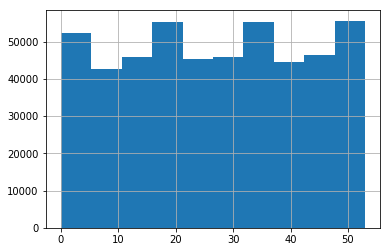

In [5]:
dev_raw['category_id'].hist()

In [6]:
from pymystem3 import Mystem
stemmer = Mystem()

def lemmatize(words):
    return [stemmer.lemmatize(word)[0] for word in words]

def prepare_data(df):
    df = df.copy()
    df['text'] = df['title'].str.cat(df['description'], ' ')
    df['tokens'] = df['text'].str.lower().apply(lambda text: tokenizer.tokenize(text))
    df['lemmatized'] = df['tokens'].apply(lemmatize)
    return df.drop(['title', 'description'],axis=1)

In [7]:
from nltk.corpus import stopwords
russian_stopwords = stopwords.words("russian")

cat_words = categories.name.str.replace('|',' ').str.lower().str.split(' ').apply(lemmatize)
cat_words = cat_words.apply(set).apply(lambda x:x.difference(russian_stopwords))

def jaccard(x):
    return [len(cat_words[i].intersection(x))/len(cat_words[i].union(x)) for i in cat_words.index]


def compute_jaccard(data):

    words = data['lemmatized'].apply(lambda x: set(x).difference(russian_stopwords))

    j = words.apply(jaccard)
    df = pd.DataFrame(j.values.tolist(), columns=[f'cat_{i}' for i in cat_words.index])
    return  df

In [8]:
def write_for_fasttext(data, column, path, label=None):
    if label is not None:
        with  open(path, 'w') as f:
            for idx, cat, lst, in data[[ 'category_id', column]].itertuples():
                text = ' '.join(lst)
                f.write(f'__label__{cat} {text}\n')
    else:
        data[column].str.join(' ').to_csv(path, index=False)

In [9]:
dev = prepare_data(dev_raw)
test = prepare_data(test_raw)

In [10]:
dev = pd.concat([dev, compute_jaccard(dev)], axis=1)
test = pd.concat([test, compute_jaccard(test)], axis=1)

In [11]:
train, valid = train_test_split(dev, test_size = 0.2, random_state=SEED, stratify=dev['category_id'])

In [12]:
dev.to_json('data/json/dev.json', orient='records', lines=True)
train.to_json('data/json/train.json', orient='records', lines=True)
valid.to_json('data/json/valid.json', orient='records', lines=True)
test.to_json('data/json/test.json', orient='records', lines=True)

In [16]:
skf = StratifiedKFold(n_splits=N_SPLITS, random_state=SEED)
for fold, (train_idx, test_idx) in enumerate(skf.split(train, train['category_id'])):
    train_fold = dev.loc[train_idx]
    test_fold = dev.loc[test_idx]
    train_fold.to_json(f'data/json/train_{fold}.json', orient='records', lines=True)
    test_fold.to_json(f'data/json/train_{fold}.json', orient='records', lines=True)
    
    write_for_fasttext(train_fold, 'lemmatized', f'./data/ft/lemmatized/train_{fold}.txt', label='category_id')
    write_for_fasttext(test_fold, 'lemmatized', f'./data/ft/lemmatized/test_{fold}.txt', label='category_id')
    
    write_for_fasttext(train_fold, 'tokens', f'./data/ft/tokens/train_{fold}.txt', label='category_id')
    write_for_fasttext(test_fold, 'tokens', f'./data/ft/tokens/test_{fold}.txt', label='category_id')

In [17]:
write_for_fasttext(train, 'lemmatized', './data/ft/lemmatized/train.txt', label='category_id')
write_for_fasttext(valid, 'lemmatized', './data/ft/lemmatized/valid.txt', label='category_id')
write_for_fasttext(dev, 'lemmatized', './data/ft/lemmatized/dev.txt', label='category_id')

In [18]:
write_for_fasttext(train, 'tokens', './data/ft/tokens/train.txt', label='category_id')
write_for_fasttext(valid, 'tokens', './data/ft/tokens/valid.txt', label='category_id')
write_for_fasttext(dev, 'tokens', './data/ft/tokens/dev.txt', label='category_id')